In [4]:
import pandas as pd
from tqdm import tqdm
from rapidfuzz import fuzz

In [5]:
website_df = pd.read_csv("website_data_with_classifications.csv")

In [6]:
website_df.head()

,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,...,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10,category
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Gifts Men | 11 Industries | Gentleman's Genera...,Gifts Men | 11 Industries | Gentleman's Genera...,Gifts Men | 11 Industries | Gentleman's Genera...,Gifts Men | 11 Industries | Gentleman's Genera...,Gifts Men | 11 Industries | Gentleman's Genera...,Gifts Men | 11 Industries | Gentleman's Genera...,Gifts Men | 11 Industries | Gentleman's Genera...,Gifts Men | 11 Industries | Gentleman's Genera...,Gifts Men | 11 Industries | Gentleman's Genera...,5651.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Distillery | 11 Wells Distillery | Saint Paul ...,Distillery | 11 Wells Distillery | Saint Paul ...,Distillery | 11 Wells Distillery | Saint Paul ...,Distillery | 11 Wells Distillery | Saint Paul ...,Distillery | 11 Wells Distillery | Saint Paul ...,Distillery | 11 Wells Distillery | Saint Paul ...,Distillery | 11 Wells Distillery | Saint Paul ...,Distillery | 11 Wells Distillery | Saint Paul ...,Distillery | 11 Wells Distillery | Saint Paul ...,2082.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"14th Rose - Handbags, Purses, Woman's Bags Fre...","14th Rose - Handbags, Purses, Woman's Bags Fre...","14th Rose - Handbags, Purses, Woman's Bags Fre...","14th Rose - Handbags, Purses, Woman's Bags Fre...","14th Rose - Handbags, Purses, Woman's Bags Fre...","14th Rose - Handbags, Purses, Woman's Bags Fre...","14th Rose - Handbags, Purses, Woman's Bags Fre...","14th Rose - Handbags, Purses, Woman's Bags Fre...","14th Rose - Handbags, Purses, Woman's Bags Fre...",3799.0
3,NaN,NaN,"Welcome Regal Ware, Inc. global leader quality...","Welcome Regal Ware, Inc. global leader quality...","Welcome Regal Ware, Inc. global leader quality...","Welcome Regal Ware, Inc. global leader quality...","Welcome Regal Ware, Inc. global leader quality...","Welcome Regal Ware, Inc. global leader quality...","Welcome Regal Ware, Inc. global leader quality...","Welcome Regal Ware, Inc. global leader quality...",...,Regal Ware | Enriching Life Bringing Families ...,Regal Ware | Enriching Life Bringing Families ...,Regal Ware | Enriching Life Bringing Families ...,Regal Ware | Enriching Life Bringing Families ...,Regal Ware | Enriching Life Bringing Families ...,Home - Regal Ware Work Core Values Story Leade...,Home - Regal Ware Work Core Values Story Leade...,Home - Regal Ware Work Core Values Story Leade...,Home - Regal Ware Work Core Values Story Leade...,5082.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Custom Swim Parkas Wholesale Fleece Jackets | ...,Custom Swim Parkas Wholesale Fleece Jackets | ...,Custom Swim Parkas Wholesale Fleece Jackets | ...,Custom Swim Parkas Wholesale Fleece Jackets | ...,Custom Swim Parkas Wholesale Fleece Jackets | ...,Custom Swim Parkas Wholesale Fleece Jackets | ...,Custom Swim Parkas Wholesale Fleece Jackets | ...,Custom Swim Parkas Wholesale Fleece Jackets | ...,Custom Swim Parkas Wholesale Fleece Jackets | ...,2369.0


In [7]:
website_df["category"].count()

4309

In [8]:
classification_col = website_df["category"]
classification_col = pd.Series([(str(int(x))[:2] if not pd.isnull(x) else "00") for x in classification_col])

In [17]:
def ngram_text(text):
    text = text.lower()
    return [text[i:i+3] for i in range(len(text)-3+1)]


In [21]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from rapidfuzz import fuzz, process
from functools import lru_cache

session_year_map = {
    2008: 110,
    2012: 112,
    2016: 114,
    2020: 116
}
# session_year_map = {2007: 110, 2008: 110, 2009: 111, 2010: 111, 2011: 112, 2012: 112, 2013: 113, 2014: 113, 2015: 114, 2016: 114, 2017: 115, 2018: 115, 2019: 116, 2020: 116}
all_website_scores = []
all_website_scores_by_category = {category: [] for category in classification_col.unique()}

sum_year_scores = []
num_websites = []
year_std_devs = []

categorized_normalized_year_scores = {category: [] for category in classification_col.unique()}
categorized_year_std_devs = {category: [] for category in classification_col.unique()}

SIMILARITY_THRESHOLD = 85

@lru_cache(maxsize=100000)
def cached_partial_ratio(phrase, token):
    return fuzz.partial_ratio(phrase, token)

def count_matches(ngrams, phrase):
    return sum(1 for ngram in ngrams if cached_partial_ratio(phrase, ngram) >= SIMILARITY_THRESHOLD)

for year in session_year_map:
    session = session_year_map[year]
    keywords_df = pd.read_csv(f"Partisan Index/{session}_congress_alpha_beta.csv")
    clean_phrases = keywords_df["phrase_clean"]
    clean_phrases = clean_phrases.dropna()
    
    year_score = 0

    valid_columns = [col for col in website_df.columns if str(year) in col]
    subset = website_df[valid_columns[-1]] # select the last value within a given year

    subset = subset.fillna("")
    subset = subset.astype(str)
    subset_split = subset.apply(ngram_text)

    phrase_count = pd.DataFrame(0, index=website_df.index, columns=keywords_df["phrase_clean"])
    for phrase in tqdm(clean_phrases, total=len(clean_phrases)):
        phrase_count[phrase] = subset.apply(lambda x: count_matches(x, phrase))

    y_n_denominator = sum(beta * beta for beta in keywords_df["beta"])

    website_scores = []
    website_scores_by_category = {category: [] for category in classification_col.unique()}

    websites_count = 0

    for website in tqdm(phrase_count.index):
        website_stats = phrase_count.loc[website]
        if not subset.loc[website]:
            continue
        phrase_count_sum = website_stats.sum()
        y_n_numerator = 0
        for phrase, beta, alpha in zip(keywords_df["phrase_clean"], keywords_df["beta"], keywords_df["alpha"]):
            y_n_numerator += beta * (((website_stats[phrase] / phrase_count_sum) if phrase_count_sum else 0) - alpha)
        year_score += y_n_numerator / y_n_denominator
        website_scores.append(y_n_numerator / y_n_denominator)
        website_category = classification_col[website]
        website_scores_by_category[website_category].append(y_n_numerator / y_n_denominator)
        websites_count += 1

    all_website_scores.append(website_scores)

    print("Websites count: ", websites_count, " Number of elements in website_scores: ", len(website_scores))

    sum_year_scores.append(np.sum(website_scores))
    num_websites.append(websites_count)
    year_std_devs.append(np.std(website_scores))

    for category in classification_col.unique():
        if len(website_scores_by_category[category]) == 0:
            print(f"Category {category} had no websites in year {year}")
        all_website_scores_by_category[category].append(website_scores_by_category[category])
        categorized_normalized_year_scores[category].append(np.mean(website_scores_by_category[category]))
        categorized_year_std_devs[category].append(np.std(website_scores_by_category[category]))

    print(f"Year {year} score: {year_score / websites_count}")

100%|██████████| 5189/5189 [00:02<00:00, 2074.18it/s]
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Websites count:  2436  Number of elements in website_scores:  2436
Category 43 had no websites in year 2008
Category 84 had no websites in year 2008
Category 86 had no websites in year 2008
Category 2 had no websites in year 2008
Category 8 had no websites in year 2008
Year 2008 score: 0.5417899088888176


100%|██████████| 5189/5189 [00:02<00:00, 1875.31it/s]
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Websites count:  3096  Number of elements in website_scores:  3096
Category 43 had no websites in year 2012
Category 84 had no websites in year 2012
Category 2 had no websites in year 2012
Category 8 had no websites in year 2012
Year 2012 score: 0.37824916094644395


100%|██████████| 5189/5189 [00:03<00:00, 1592.46it/s]
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Websites count:  3820  Number of elements in website_scores:  3820
Category 84 had no websites in year 2016
Category 2 had no websites in year 2016
Year 2016 score: 0.3388524165648646


100%|██████████| 5189/5189 [00:03<00:00, 1513.83it/s]

Websites count:  4341  Number of elements in website_scores:  4341
Year 2020 score: 0.4344898724270198


In [22]:
import numpy as np
print([np.mean(scores) for scores in all_website_scores])
print([np.std(scores) for scores in all_website_scores])

[0.5417899088888187, 0.3782491609464437, 0.3388524165648637, 0.43448987242701953]
[0.0007537772995588702, 0.0013398883400320702, 0.0006168875531724496, 0.0004996482249967749]


In [23]:
print([np.sum(scores) for scores in all_website_scores])

[1319.8002180531626, 1171.0594022901896, 1294.4162312777794, 1886.1205362056917]


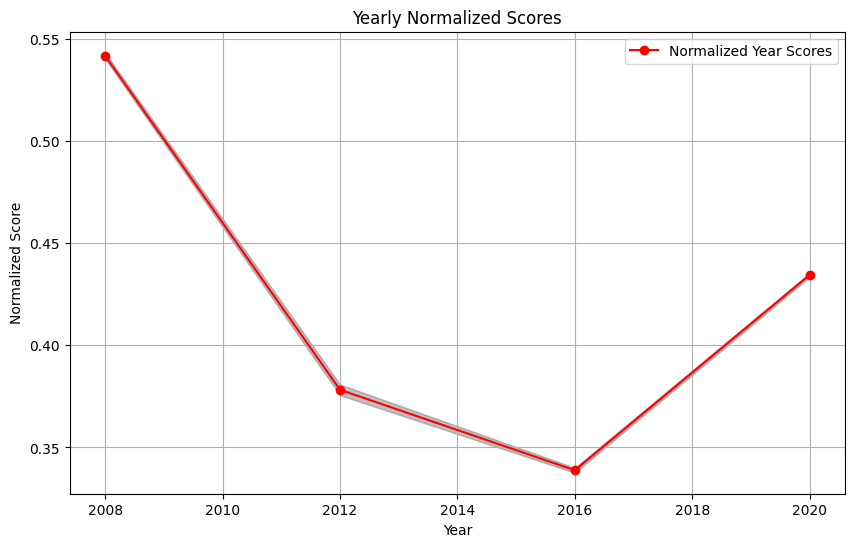

In [24]:
import matplotlib.pyplot as plt

years = list(session_year_map.keys())
normalized_year_scores = [np.mean(scores) for scores in all_website_scores]

plt.figure(figsize=(10, 6))
plt.plot(years, normalized_year_scores, marker='o', color='r', label='Normalized Year Scores')
plt.fill_between(years, 
                 [score - 1.96*std for score, std in zip(normalized_year_scores, year_std_devs)], 
                 [score + 1.96*std for score, std in zip(normalized_year_scores, year_std_devs)], 
                 color='gray', alpha=0.5)
plt.xlabel('Year')
plt.ylabel('Normalized Score')
plt.title('Yearly Normalized Scores')
plt.legend()
plt.grid(True)
plt.show()